In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets


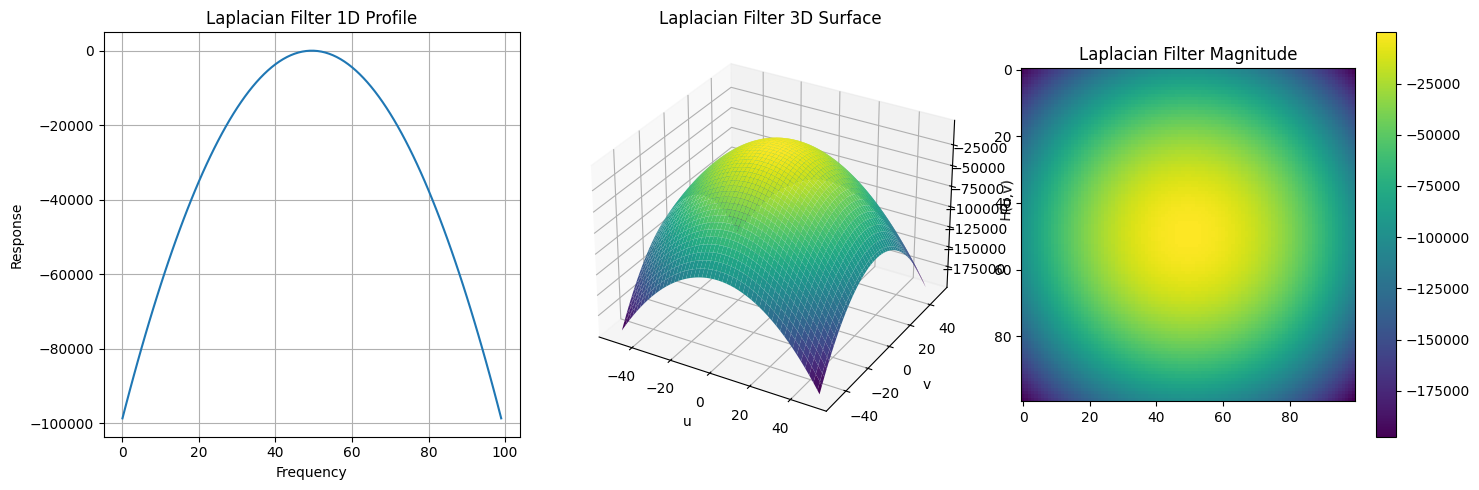

In [2]:

def create_frequency_grid(size):
    """Create a 2D frequency grid centered at (size//2, size//2)."""
    x = np.linspace(-size//2, size//2, size)
    y = np.linspace(-size//2, size//2, size)
    X, Y = np.meshgrid(x, y)
    return X, Y

def laplacian_filter(X, Y):
    """Create Laplacian filter in frequency domain.
    H(u,v) = -4π²(u² + v²)
    """
    return -4 * np.pi**2 * (X**2 + Y**2)

def scaled_laplacian_filter(X, Y, scaling_factor=1.0):
    """Create scaled Laplacian filter in frequency domain.
    Allows control over the strength of the filter.
    """
    return scaling_factor * laplacian_filter(X, Y)

def create_test_images(size=256):
    """Create multiple test images with pronounced edges."""
    # 1. Checkerboard pattern
    checkerboard = np.zeros((size, size))
    tile_size = size // 16
    for i in range(size):
        for j in range(size):
            if ((i // tile_size) + (j // tile_size)) % 2 == 0:
                checkerboard[i, j] = 1

    # 2. Geometric shapes
    shapes = np.zeros((size, size))
    # Add rectangle
    shapes[size//4:3*size//4, size//4:3*size//4] = 1
    # Add circle
    center = size // 2
    radius = size // 6
    y, x = np.ogrid[-center:size-center, -center:size-center]
    mask = x*x + y*y <= radius*radius
    shapes[mask] = 0.5
    # Add diagonal line
    np.fill_diagonal(shapes, 1)

    # 3. Text-like pattern (E letter)
    text = np.zeros((size, size))
    # Vertical line
    text[size//4:3*size//4, size//4:(size//4 + size//20)] = 1
    # Horizontal lines
    text[size//4:(size//4 + size//20), size//4:2*size//3] = 1  # Top
    text[size//2:(size//2 + size//20), size//4:2*size//3] = 1  # Middle
    text[3*size//4:(3*size//4 + size//20), size//4:2*size//3] = 1  # Bottom

    return {
        'Checkerboard': checkerboard,
        'Geometric': shapes,
        'Text': text
    }

def plot_laplacian_response(scaling_factor=1.0):
    """Visualize the Laplacian filter response."""
    size = 100
    X, Y = create_frequency_grid(size)

    # Create Laplacian filter
    H = scaled_laplacian_filter(X, Y, scaling_factor)

    # Create visualization
    fig = plt.figure(figsize=(15, 5))

    # 1D Profile
    ax1 = fig.add_subplot(131)
    center = size // 2
    ax1.plot(H[center, :])
    ax1.set_title('Laplacian Filter 1D Profile')
    ax1.set_xlabel('Frequency')
    ax1.set_ylabel('Response')
    ax1.grid(True)

    # 3D Surface
    ax2 = fig.add_subplot(132, projection='3d')
    surf = ax2.plot_surface(X, Y, H, cmap='viridis')
    ax2.set_title('Laplacian Filter 3D Surface')
    ax2.set_xlabel('u')
    ax2.set_ylabel('v')
    ax2.set_zlabel('H(u,v)')

    # Magnitude Image
    ax3 = fig.add_subplot(133)
    im = ax3.imshow(H, cmap='viridis')
    ax3.set_title('Laplacian Filter Magnitude')
    plt.colorbar(im, ax=ax3)

    plt.tight_layout()
    plt.show()

def apply_laplacian_filter(img, scaling_factor=1.0):
    """Apply Laplacian filter to an image."""
    if len(img.shape) > 2:
        img = np.mean(img, axis=2)  # Convert to grayscale

    # Get centered FFT
    f = np.fft.fft2(img)
    fshift = np.fft.fftshift(f)

    # Create frequency grid and filter
    X, Y = create_frequency_grid(img.shape[0])
    H = scaled_laplacian_filter(X, Y, scaling_factor)

    # Apply filter
    filtered_shift = fshift * H
    filtered_image = np.real(np.fft.ifft2(np.fft.ifftshift(filtered_shift)))

    # Plot results
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))

    # Original image
    axes[0,0].imshow(img, cmap='gray')
    axes[0,0].set_title('Original Image')

    # Original spectrum
    magnitude_spectrum = np.log(np.abs(fshift) + 1)
    axes[0,1].imshow(magnitude_spectrum, cmap='gray')
    axes[0,1].set_title('Original Spectrum')

    # Filter response
    axes[0,2].imshow(H, cmap='viridis')
    axes[0,2].set_title('Laplacian Filter')

    # Filtered image
    axes[1,0].imshow(filtered_image, cmap='gray')
    axes[1,0].set_title('Laplacian Filtered')

    # Filtered spectrum
    filtered_spectrum = np.log(np.abs(filtered_shift) + 1)
    axes[1,1].imshow(filtered_spectrum, cmap='gray')
    axes[1,1].set_title('Filtered Spectrum')

    # Enhanced image
    enhanced_image = img + scaling_factor * filtered_image
    axes[1,2].imshow(enhanced_image, cmap='gray')
    axes[1,2].set_title('Enhanced Image\n(Original + Laplacian)')

    for ax in axes.flat:
        ax.axis('off')

    plt.tight_layout()
    plt.show()

# Show Laplacian filter response
plot_laplacian_response()

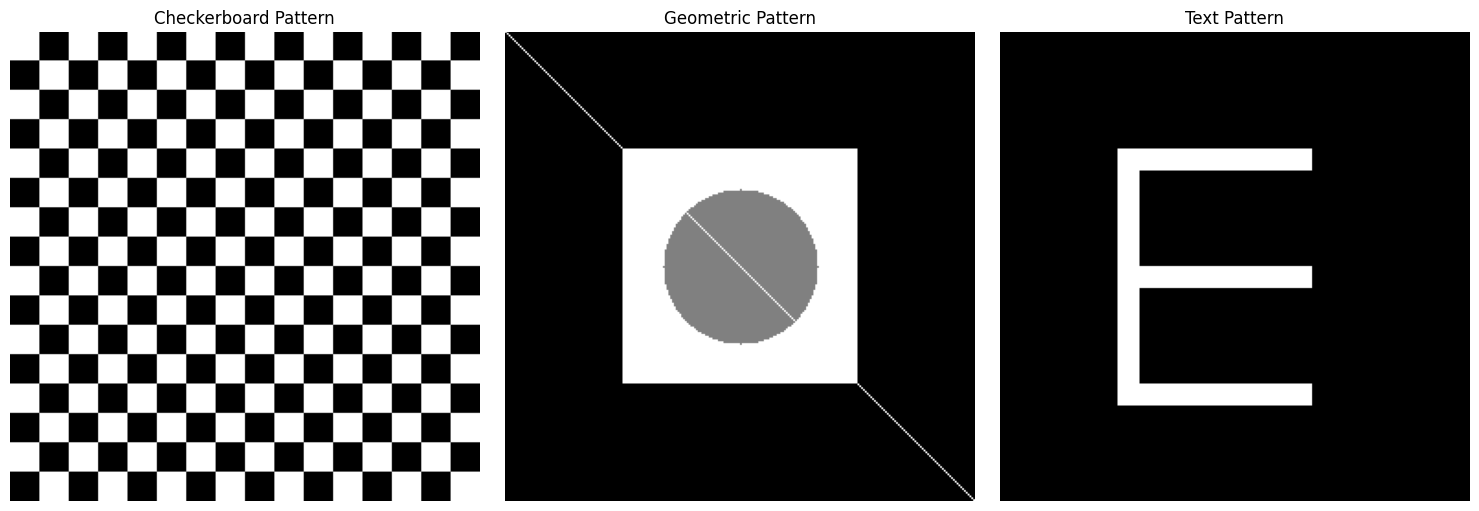

In [3]:
# Generate test images
test_images = create_test_images(256)

# Display all test images
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
for idx, (name, img) in enumerate(test_images.items()):
    axes[idx].imshow(img, cmap='gray')
    axes[idx].set_title(f'{name} Pattern')
    axes[idx].axis('off')
plt.tight_layout()
plt.show()



In [4]:
# Create interactive widget for image filtering
image_dropdown = widgets.Dropdown(
    options=test_images.keys(),
    description='Image:',
    value='Geometric'
)

@interact
def interactive_filtering(
    image=image_dropdown,
    scaling_factor=widgets.FloatSlider(
        value=1.0,
        min=0.1,
        max=5.0,
        step=0.1,
        description='Scale:',
        continuous_update=False
    )
):
    """Interactive Laplacian filtering with image selection and scaling."""
    apply_laplacian_filter(test_images[image], scaling_factor)

interactive(children=(Dropdown(description='Image:', index=1, options=('Checkerboard', 'Geometric', 'Text'), v…